In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

2023-06-22 13:15:58.867598: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 13:15:59.977056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Main data set https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
# Additional data set https://www.kaggle.com/datasets/atulanandjha/lfwpeople

import zipfile
from bs4 import BeautifulSoup

archive = zipfile.ZipFile('archive.zip', 'r')
annotations = [f for f in archive.namelist() if f.startswith("annotations")]
bs = [BeautifulSoup(archive.read(f), "xml") for f in annotations]

In [3]:
bs[0]

<?xml version="1.0" encoding="utf-8"?>
<annotation>
<folder>images</folder>
<filename>maksssksksss0.png</filename>
<size>
<width>512</width>
<height>366</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>without_mask</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>79</xmin>
<ymin>105</ymin>
<xmax>109</xmax>
<ymax>142</ymax>
</bndbox>
</object>
<object>
<name>with_mask</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>185</xmin>
<ymin>100</ymin>
<xmax>226</xmax>
<ymax>144</ymax>
</bndbox>
</object>
<object>
<name>without_mask</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>325</xmin>
<ymin>90</ymin>
<xmax>360</xmax>
<ymax>141</ymax>
</bndbox>
</object>
</annotation>

In [4]:
# Zdjecia z jedna osoba

single_person = [f for f in bs if len(f.find_all("object")) == 1]

In [5]:
len(single_person)

329

In [6]:
def person_area(p):
    return (int(p.find("xmax").text)-int(p.find("xmin").text))*(int(p.find("ymax").text)-int(p.find("ymin").text))/(int(p.find("width").text)*int(p.find("height").text))

In [7]:
len([f for f in single_person if f.find("depth").text != "3"])

0

In [8]:
print(len([p for p in single_person if person_area(p) > 0.05]))
len([p for p in single_person if p.find("name").text == "without_mask"])

267


52

In [9]:
pcts = [person_area(p) for p in single_person if p.find("name").text == "without_mask"]
pcts = [p for p in pcts if p > 0.05]
len(pcts)

51

In [10]:
single_person[pcts.index(min(pcts))]

<?xml version="1.0" encoding="utf-8"?>
<annotation>
<folder>images</folder>
<filename>maksssksksss125.png</filename>
<size>
<width>301</width>
<height>400</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>without_mask</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>118</xmin>
<ymin>151</ymin>
<xmax>216</xmax>
<ymax>279</ymax>
</bndbox>
</object>
</annotation>

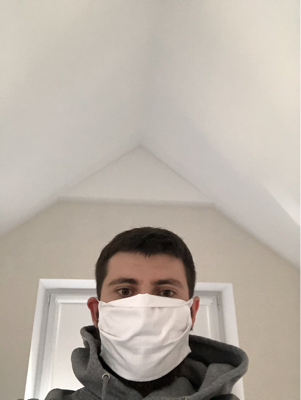

In [11]:
from keras.utils import load_img
from keras.utils import img_to_array
from matplotlib import pyplot
from PIL import Image
import io

gen = (p.find("filename").text for p in single_person if p.find("name").text != "without_mask")
for i in range(1):
    image = Image.open(io.BytesIO(archive.read("images/" + next(gen))))
    image.show()

In [12]:
import pandas as pd

init_df=pd.DataFrame(
    [("images/" + p.find("filename").text, "nomask" if p.find("name").text == "without_mask" else "mask") for p in single_person],
    columns=["file","mask"])
init_df

,file,mask
0,images/maksssksksss10.png,mask
1,images/maksssksksss101.png,mask
2,images/maksssksksss102.png,mask
3,images/maksssksksss106.png,mask
4,images/maksssksksss107.png,mask
...,...,...
324,images/maksssksksss851.png,mask
325,images/maksssksksss87.png,mask
326,images/maksssksksss88.png,mask
327,images/maksssksksss95.png,nomask


In [13]:
init_df["mask"].value_counts()

mask
mask      277
nomask     52
Name: count, dtype: int64

In [14]:
import os

lfws = [dirpath+"/"+filenames[0] for dirpath, dirnames, filenames in os.walk("lfw_funneled") if filenames[0].endswith("jpg")]

In [15]:
lfws_df = pd.DataFrame([{"file": f, "mask":"nomask"} for f in lfws[:220]])
lfws_df

,file,mask
0,lfw_funneled/Ellen_Saracini/Ellen_Saracini_000...,nomask
1,lfw_funneled/Lydia_Shum/Lydia_Shum_0001.jpg,nomask
2,lfw_funneled/Yale_Kamisar/Yale_Kamisar_0001.jpg,nomask
3,lfw_funneled/Pinar_del_Rio/Pinar_del_Rio_0001.jpg,nomask
4,lfw_funneled/Larry_Tanenbaum/Larry_Tanenbaum_0...,nomask
...,...,...
215,lfw_funneled/Rudi_Voeller/Rudi_Voeller_0001.jpg,nomask
216,lfw_funneled/Juergen_Peters/Juergen_Peters_000...,nomask
217,lfw_funneled/Peter_Lundgren/Peter_Lundgren_000...,nomask
218,lfw_funneled/Vojislav_Seselj/Vojislav_Seselj_0...,nomask


In [16]:
df=pd.concat([init_df, lfws_df])

In [17]:
df["mask"].value_counts()

mask
mask      277
nomask    272
Name: count, dtype: int64

In [18]:
from sklearn.model_selection import train_test_split

train_df,test_df = train_test_split(df,test_size=0.2)

In [19]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2, 
                                   zoom_range=0.2,
                                   rotation_range=45,
                                 horizontal_flip=True)
train_generator=train_datagen.flow_from_dataframe(dataframe=train_df, directory="./", x_col="file", y_col="mask", classes=["mask","nomask"], class_mode="binary", target_size=(150,150), batch_size=32)

test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_dataframe(dataframe=test_df, directory="./", x_col="file", y_col="mask", classes=["mask","nomask"],class_mode="binary", target_size=(150,150), batch_size=32)

Found 439 validated image filenames belonging to 2 classes.
Found 110 validated image filenames belonging to 2 classes.


In [20]:
import tensorflow as tf

model  = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3) , activation = 'relu',input_shape = (150 , 150 , 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3) , activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3,3) , activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.summary()

2023-06-22 13:16:05.711527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-22 13:16:05.857427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-22 13:16:05.857837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-22 13:16:05.861777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-22 13:16:05.862106: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 64)        0

In [21]:
model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])

In [22]:
early_stopping = keras.callbacks.EarlyStopping(patience=8,monitor="val_loss")
history = model.fit(train_generator, validation_data=test_generator, epochs = 50, callbacks=[early_stopping])

Epoch 1/50


2023-06-22 13:16:07.957644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-22 13:16:08.607406: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-22 13:16:13.192944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-22 13:16:16.195315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-22 13:16:16.223165: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f48d2cc0830 in

14/14 [==============================] - ETA: 0s - loss: 2.0290 - accuracy: 0.5125

2023-06-22 13:16:23.474615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


14/14 [==============================] - 16s 401ms/step - loss: 2.0290 - accuracy: 0.5125 - val_loss: 0.6875 - val_accuracy: 0.4818
Epoch 2/50
14/14 [==============================] - 4s 254ms/step - loss: 0.6247 - accuracy: 0.6856 - val_loss: 0.6666 - val_accuracy: 0.5818
Epoch 3/50
14/14 [==============================] - 4s 254ms/step - loss: 0.3983 - accuracy: 0.8269 - val_loss: 0.4496 - val_accuracy: 0.8091
Epoch 4/50
14/14 [==============================] - 3s 245ms/step - loss: 0.2836 - accuracy: 0.8884 - val_loss: 0.4978 - val_accuracy: 0.8182
Epoch 5/50
14/14 [==============================] - 3s 237ms/step - loss: 0.2164 - accuracy: 0.9226 - val_loss: 0.3970 - val_accuracy: 0.8636
Epoch 6/50
14/14 [==============================] - 4s 242ms/step - loss: 0.2499 - accuracy: 0.9043 - val_loss: 0.6095 - val_accuracy: 0.7545
Epoch 7/50
14/14 [==============================] - 4s 254ms/step - loss: 0.2481 - accuracy: 0.8975 - val_loss: 0.5118 - val_accuracy: 0.8273
Epoch 8/50
14/14

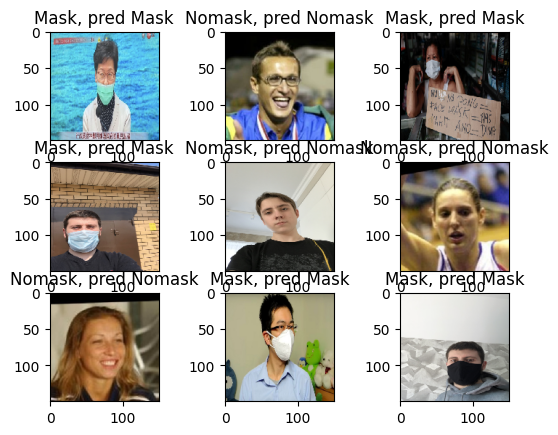

In [27]:
def show_model_preds(model):
    for i in range(9):
        pyplot.subplot(330 + 1 + i)
        batch = test_generator.next()
        pyplot.title(("Nomask" if batch[1][0] == 1.0 else "Mask") + ", pred " + ("Nomask" if model(np.array([batch[0][0]])) > 0.5 else "Mask"))
        pyplot.imshow((batch[0][0] * 255).astype('uint8'))

show_model_preds(model)

In [24]:
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam

base_model = InceptionV3(weights='imagenet', input_shape = (150 , 150 , 3), include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model_pretrained = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model_pretrained.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model_pretrained.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d_3[0][0]']               
 alization)                                                                                       
                                                                                              

In [25]:
early_stopping = keras.callbacks.EarlyStopping(patience=8,monitor="val_loss")
history_pretrained = model_pretrained.fit(train_generator, validation_data=test_generator, epochs = 50, callbacks=[early_stopping])

Epoch 1/50


2023-06-22 13:18:14.358492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


14/14 [==============================] - ETA: 0s - loss: 1.7442 - accuracy: 0.7403

2023-06-22 13:18:22.731239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


14/14 [==============================] - 11s 516ms/step - loss: 1.7442 - accuracy: 0.7403 - val_loss: 0.1866 - val_accuracy: 0.9273
Epoch 2/50
14/14 [==============================] - 4s 259ms/step - loss: 0.1260 - accuracy: 0.9453 - val_loss: 0.3217 - val_accuracy: 0.9273
Epoch 3/50
14/14 [==============================] - 4s 257ms/step - loss: 0.1549 - accuracy: 0.9522 - val_loss: 0.1419 - val_accuracy: 0.9455
Epoch 4/50
14/14 [==============================] - 3s 246ms/step - loss: 0.0645 - accuracy: 0.9749 - val_loss: 0.1199 - val_accuracy: 0.9636
Epoch 5/50
14/14 [==============================] - 4s 252ms/step - loss: 0.0637 - accuracy: 0.9772 - val_loss: 0.1091 - val_accuracy: 0.9727
Epoch 6/50
14/14 [==============================] - 4s 256ms/step - loss: 0.0543 - accuracy: 0.9749 - val_loss: 0.1195 - val_accuracy: 0.9727
Epoch 7/50
14/14 [==============================] - 4s 272ms/step - loss: 0.0427 - accuracy: 0.9886 - val_loss: 0.1326 - val_accuracy: 0.9818
Epoch 8/50
14/14

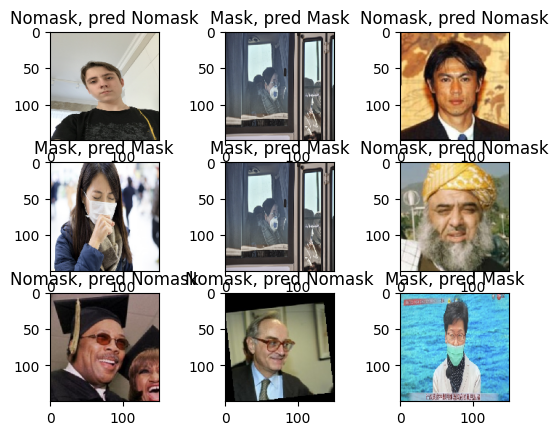

In [31]:
show_model_preds(model_pretrained)

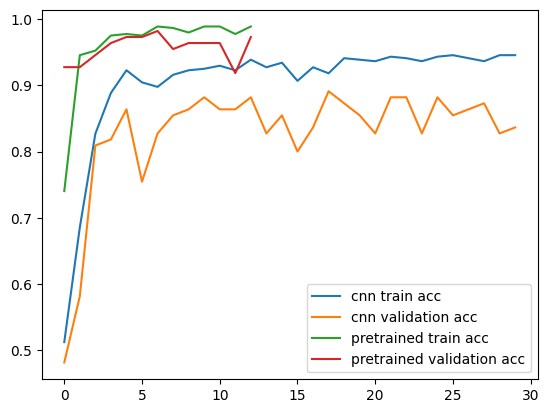

In [26]:
plt.plot(history.history["accuracy"], label = 'cnn train acc')
plt.plot(history.history['val_accuracy'], label = 'cnn validation acc')
plt.plot(history_pretrained.history["accuracy"], label = 'pretrained train acc')
plt.plot(history_pretrained.history['val_accuracy'], label = 'pretrained validation acc')
plt.legend()
plt.show()